<a href="https://colab.research.google.com/github/David-Carballo/2023w-project-pose/blob/main/YogaPostureCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports and Data

Download and install OpenPose


In [ ]:
!pip install git+https://github.com/prasunroy/openpose-pytorch.git

Import necessary libraries

In [2]:
import sys
import os
import cv2
from openpose.body.estimator import BodyPoseEstimator
from openpose.utils import draw_body_connections, draw_keypoints
from google.colab.patches import cv2_imshow 
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets.utils import list_files
from torchvision.datasets.folder import pil_loader
from torchvision.utils import make_grid
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
from torchvision.io import read_image
from torchvision.io import ImageReadMode
from PIL import Image
import zipfile
import albumentations as A
import random
from torchvision.transforms import ToPILImage
import shutil
from collections import defaultdict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sn
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cuda'

In [3]:
seed = 123
np.random.seed(seed)
_ = torch.manual_seed(seed)
_ = torch.cuda.manual_seed(seed)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Download dataset

In [5]:
# nombre del archivo zip
zip_file = '/content/drive/MyDrive/Postgrau AI/Dataset Yoga Poses.zip' #'/content/drive/MyDrive/YogaPostureDataset.zip'
# ruta donde se descomprimirá el archivo
extract_to = '/content/descomprimido'
# descomprimir el archivo
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

In [6]:
import json

# Save the name of all classes in sanskrit and english
poses_dict = {}

with open('descomprimido/Poses.json') as f:
    data = json.load(f)
    for pose in data['Poses']:
        poses_dict[pose['sanskrit_name']] = pose['english_name']
    
!rm 'descomprimido/Poses.json'

#EfficientNet

In [7]:
class YogaDataset(Dataset):
    def __init__(self, data_dir, transforms = False, train = 0):
        self.data_dir = data_dir
        self.transforms = transforms
        
        self.train = train
        self.images, self.labels = self.load_data(data_dir)
        self.images = [Image.open(img_path).convert('RGB') for img_path in self.images] 

    def __getitem__(self, index):
        img = self.images[index]
        if self.transforms == True:
            if random.random() < 0.75:
                img = self.data_augmentation(img=np.array(img))['image']
        tensor_img = transforms.ToTensor()(img)
        tensor_img = self.image_transform(tensor_img)
        label = self.labels[index]

        return tensor_img, label

    def load_data(self, data_dir):
        images = []
        labels = []
        for i, subdir in enumerate(sorted(os.listdir(data_dir))):
                    subdir_path = os.path.join(data_dir, subdir)
                    if os.path.isdir(subdir_path):
                        for file in sorted(os.listdir(subdir_path)):
                            file_path = os.path.join(subdir_path, file)
                            if file_path.endswith('.jpg') or file_path.endswith('.jpeg') or file_path.endswith('.png'):
                                images.append(file_path)
                                labels.append(i)
        
        
        #Shuffle images
        random.seed(1)
        
        idx = [x for x in range(0,2756)]
        random.shuffle(idx)

        data = []
        new_labels = []
        for i in idx:
            data.append(images[i])
            new_labels.append(labels[i])

        n = int(len(images) * 0.6)
        aux = int(len(images) * 0.2)
        m = n+aux
        print(idx[n])
        if self.train == 0:
          return data[:n], new_labels[:n]
        elif self.train == 1:
          return data[n:m], new_labels[n:m]
        else:
          return data[m:], new_labels[m:]
    
    def image_transform(self, tensor):
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        resize = transforms.Resize(224)
        #Check if image size ratio is 1:1
        if tensor.shape[1] != tensor.shape[2]:
            #Calculate difference between X and Y axis
            diff = tensor.shape[1] - tensor.shape[2]
            #Check what dimension needs to be padded either the X (dimension 1 of the tensor, right), or the Y (dimension 3, bottom)
            if diff > 0:     
                tensor = F.pad(input=tensor, pad=(0, abs(diff), 0, 0), mode='constant', value=0) #pad(left, right, top, bottom)
            else:
                tensor = F.pad(input=tensor, pad=(0, 0, 0, abs(diff)), mode='constant', value=0)
        tensor = resize(tensor)
        tensor = tensor.reshape(3, 224, 224)
        return tensor

    def data_augmentation(self, img):
        da_transforms = A.Compose([
        A.HorizontalFlip(p = 0.5),
        A.GaussianBlur(p = 0.5),
        A.HueSaturationValue(p = 0.5),
        A.ColorJitter(p = 0.5),
        ])

        # apply data augmentation transforms
        img = da_transforms(image=np.array(img))['image']
        
        return {'image': img}

    def get_images(self):
      return self.images
    
    def get_labels(self):
      return self.labels

    def __len__(self):
        return len(self.images)

In [8]:
num_classes = 47

47 clases

In [ ]:
#(train = 0 -> Training dataset, 1 -> Validation Dataset, 2 -> Test Dataset)
train_dataset = YogaDataset('descomprimido', transforms = True, train = 0)
val_dataset = YogaDataset('descomprimido', transforms = False, train = 1)
test_dataset = YogaDataset('descomprimido', transforms = False, train = 2)

In [ ]:
print('Number of images', len(train_dataset)+len(test_dataset)+len(val_dataset))
print(len(train_dataset),len(test_dataset),len(val_dataset))
print(train_dataset[0])
print(test_dataset[0])
print(val_dataset[0])

In [ ]:
image, label = train_dataset[145]

# convert the tensor image to a PIL Image
to_pil = ToPILImage()
pil_image = to_pil(image)

# plot the image and show its corresponding label
plt.imshow(pil_image)
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()

In [10]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(len(train_loader))

52


In [11]:
img_model = torchvision.models.efficientnet_b3(weights='DEFAULT')
#Substitution of the model's last layer so it predicts between the 47 classes of the Dataset instead of the 1000 of Imagenet
img_model.classifier = nn.Sequential(
    nn.BatchNorm1d(1536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.Linear(in_features=1536, out_features=50, bias=True),
    nn.Dropout(p=0.5, inplace=True),
    nn.Linear(in_features=50, out_features=47, bias=True),
    nn.LogSoftmax(dim = -1)  
)


for param in img_model.parameters():
    param.requires_grad = True
for param in img_model.classifier.parameters():
    param.requires_grad = True

img_model.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-cf984f9c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-cf984f9c.pth


  0%|          | 0.00/47.2M [00:00<?, ?B/s]

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [12]:
criterion = nn.NLLLoss()
optimizer = optim.AdamW(
    [
        {"params": img_model.features.parameters(), "lr": 1e-5},
        {"params": img_model.classifier.parameters(), "lr": 1e-4},
    ],weight_decay = 0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [13]:
def train(model, train_loader, criterion, optimizer, device, num_epochs, num_classes):
  
    model.train()
    train_loss_list = []
    train_acc_list = []
    val_acc_list = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Calculate statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Update train loss and accuracy once per epoch
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)

        # Run validation loop once per epoch and update val accuracy
        val_acc = validate(model, val_loader, criterion, device)
        val_acc_list.append(val_acc)

        print('[Epoch %d] Train Loss: %.3f, Train Acc: %.3f, Val Acc: %.3f' %
              (epoch + 1, train_loss, train_acc, val_acc))

    # Plot train and val accuracy once training is finished
    plt.plot(train_acc_list)
    plt.plot(val_acc_list)
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(['Train', 'Validation'])
    plt.show()

    print('Finished Training')

In [14]:
def validate(model, val_loader, criterion, device):
    model.eval()  # set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data[0].to(device), data[1].to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Calculate statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate accuracy
    accuracy = 100 * correct / total

    # Print validation statistics
    print('Validation Loss: %.3f, Accuracy: %.3f' %
          (running_loss / len(val_loader), accuracy))

    return accuracy

Validation Loss: 3.676, Accuracy: 8.167
[Epoch 1] Train Loss: 3.874, Train Acc: 3.811, Val Acc: 8.167
Validation Loss: 3.337, Accuracy: 23.593
[Epoch 2] Train Loss: 3.507, Train Acc: 17.120, Val Acc: 23.593
Validation Loss: 2.726, Accuracy: 38.113
[Epoch 3] Train Loss: 2.932, Train Acc: 35.874, Val Acc: 38.113
Validation Loss: 1.920, Accuracy: 53.539
[Epoch 4] Train Loss: 2.061, Train Acc: 56.201, Val Acc: 53.539
Validation Loss: 1.409, Accuracy: 62.613
[Epoch 5] Train Loss: 1.220, Train Acc: 73.503, Val Acc: 62.613
Validation Loss: 1.166, Accuracy: 69.510
[Epoch 6] Train Loss: 0.788, Train Acc: 80.641, Val Acc: 69.510
Validation Loss: 1.042, Accuracy: 71.506
[Epoch 7] Train Loss: 0.539, Train Acc: 86.993, Val Acc: 71.506
Validation Loss: 0.981, Accuracy: 72.777
[Epoch 8] Train Loss: 0.362, Train Acc: 91.410, Val Acc: 72.777
Validation Loss: 0.963, Accuracy: 73.684
[Epoch 9] Train Loss: 0.260, Train Acc: 94.374, Val Acc: 73.684
Validation Loss: 0.976, Accuracy: 74.229
[Epoch 10] Train 

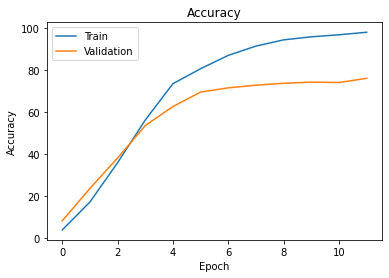

Finished Training


In [15]:
num_epochs = 12
train(img_model, train_loader, criterion, optimizer, device, num_epochs, num_classes)

In [16]:
validate(img_model, val_loader, criterion, device)

Validation Loss: 0.953, Accuracy: 76.044


76.04355716878403

In [17]:
def test(model, test_loader, criterion, device):
    model.eval()  # set model to evaluation mode
    precision = defaultdict(lambda: 0)
    recall = defaultdict(lambda: 0)
    running_loss = 0.0
    correct = 0
    total = 0
    class_correct = defaultdict(lambda: 0)
    class_total = defaultdict(lambda: 0)
    class_true_positive = defaultdict(lambda: 0)
    class_false_positive = defaultdict(lambda: 0)
    class_false_negative = defaultdict(lambda: 0)

    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Calculate statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            for c in range(num_classes):
                class_correct[c] += ((predicted == labels) & (labels == c)).sum().item()
                class_total[c] += (labels == c).sum().item()
                class_true_positive[c] += ((predicted == labels) & (labels == c)).sum().item()
                class_false_positive[c] += ((predicted == c) & (labels != c)).sum().item()
                class_false_negative[c] += ((predicted != c) & (labels == c)).sum().item()
        # Calculate precision and recall by class
    for c in range(num_classes):
        if class_correct[c] + class_false_positive[c] == 0:
            precision[c] = 0
        else:
            precision[c] = class_true_positive[c] / (class_correct[c] + class_false_positive[c])
        if class_correct[c] + class_false_negative[c] == 0:
            recall[c] = 0
        else:
            recall[c] = class_true_positive[c] / (class_correct[c] + class_false_negative[c])
    print('Precision by class:', dict(precision))
    print('Recall by class:', dict(recall))

    # Print test statistics
    print('Test Loss: %.3f, Accuracy: %.3f' %
          (running_loss / len(test_loader), 100 * correct / total))

    return 100 * correct / total

In [18]:
test(img_model, test_loader, criterion, device)

Precision by class: {0: 0.65, 1: 0.7333333333333333, 2: 1.0, 3: 0.6153846153846154, 4: 0.8, 5: 0.8181818181818182, 6: 0.5, 7: 0.5, 8: 0.0, 9: 0.6842105263157895, 10: 0.7692307692307693, 11: 0.7142857142857143, 12: 0.75, 13: 0.9230769230769231, 14: 0.9, 15: 0.7142857142857143, 16: 0.7083333333333334, 17: 0.6666666666666666, 18: 0.6666666666666666, 19: 1.0, 20: 0.75, 21: 1.0, 22: 0.7894736842105263, 23: 0.3333333333333333, 24: 0.7142857142857143, 25: 0.6363636363636364, 26: 0.9, 27: 0.6363636363636364, 28: 1.0, 29: 0.8, 30: 0.9166666666666666, 31: 0.8, 32: 0.0, 33: 0.6, 34: 1.0, 35: 0.75, 36: 0.8125, 37: 0.875, 38: 0.9166666666666666, 39: 0.8888888888888888, 40: 0.9, 41: 0.7894736842105263, 42: 0.6153846153846154, 43: 0.6, 44: 1.0, 45: 0.7272727272727273, 46: 0.8333333333333334}
Recall by class: {0: 0.9285714285714286, 1: 0.6470588235294118, 2: 0.25, 3: 0.6666666666666666, 4: 0.8888888888888888, 5: 0.8181818181818182, 6: 1.0, 7: 0.25, 8: 0.0, 9: 0.8125, 10: 0.8333333333333334, 11: 0.7142

76.44927536231884

# AnglesMLP

In [19]:
import math

#Given the points A,B and C, compute the angle formed by the vectors AB and BC
def compute_angle(ax,ay, bx,by, cx,cy):
    dot_product = (bx - ax) * (cx - bx) + (by - ay) * (cy - by)
    mag0 = math.sqrt((bx - ax)**2 + (by - ay)**2)
    mag1 = math.sqrt((cx - bx)**2 + (cy - by)**2)
    angle = math.acos(dot_product / (mag0 * mag1))

    return angle

#Given the keypoints of the pose, calculate its angle
def get_angles(keypoints):
    n = len(keypoints)
    output = torch.empty(n,13)
    
    i = 0
    for kps in keypoints:
        #Connections of each vector
        connections =  [(0,1,2), (1,2,3), (2,3,4), (0,1,5), (1,5,6), (5,6,7), (1,2,8), (2,8,9), (8,9,10), (1,5,11), (5,11,12), (11,12,13)]

        angles = []
        #Get horizontal reference for first angle
        Ax = kps[0][0] - 20
        Ay = kps[0][1]
        Bx = kps[0][0]
        By = kps[0][1]
        Cx = kps[1][0]
        Cy = kps[1][1]
        first_angle = compute_angle(Ax, Ay, Bx, By, Cx, Cy)
        angles.append(first_angle)
        #Get rest of angles
        for a,b,c in connections:
            Ax = kps[a][0]
            Ay = kps[a][1]
            Bx = kps[b][0]
            By = kps[b][1]
            Cx = kps[c][0]
            Cy = kps[c][1]
            
            angle_deg = compute_angle(Ax, Ay, Bx, By, Cx, Cy)
            angles.append(angle_deg)
        output[i] = torch.FloatTensor(angles)
        i +=1
    output = torch.nan_to_num(output)
    return output

In [20]:
# Load precomputed keypoints from file (Download from Github repository)
load_keypoints = torch.load('keypoints')

In [21]:
class AnglesDataset(Dataset):
    def __init__(self, data_dir, transforms=False, train=0, keypoints=None):
        self.data_dir = data_dir
        self.transforms = transforms

        self.train = train
        self.images, self.labels, self.angles = self.load_data(data_dir,keypoints)
         
    def __getitem__(self, index):
        ang = self.angles[index]
        
        if self.transforms == True:
            if random.random() < 0.75:
                ang = self.add_noise(ang,30)

        return ang, self.labels[index]

    def load_data(self, data_dir, keypoints):
        images = []
        labels = []
        for i, subdir in enumerate(sorted(os.listdir(data_dir))):
                    subdir_path = os.path.join(data_dir, subdir)
                    if os.path.isdir(subdir_path):
                        for file in sorted(os.listdir(subdir_path)):
                            file_path = os.path.join(subdir_path, file)
                            if file_path.endswith('.jpg') or file_path.endswith('.jpeg') or file_path.endswith('.png'):
                                images.append(file_path)
                                labels.append(i)
        angles = get_angles(keypoints)

        #Shuffle images
        random.seed(1)
        
        idx = [x for x in range(0,2756)]
        random.shuffle(idx)

        data = []
        new_labels = []
        new_keypoints = []
        new_angles = []
        for i in idx:
            data.append(images[i])
            new_labels.append(labels[i])
            new_angles.append(angles[i])
        
        n = int(len(images) * 0.6)
        aux = int(len(images) * 0.2)
        m = n+aux

        if self.train == 0:
          return data[:n], new_labels[:n], new_angles[:n]
        elif self.train == 1:
          return data[n:m], new_labels[n:m], new_angles[n:m]
        else:
          return data[m:], new_labels[m:], new_angles[m:]

    def get_images(self):
      return self.images
    
    def get_labels(self):
      return self.labels

    def add_noise(self,angles, alpha):
        new_ang = angles.clone()
        n = random.uniform(-alpha,alpha) * math.pi / 180
        
        for i,a in enumerate(angles):
            if angles[i] > 0:
                new_ang[i] = max(0, angles[i] + n)
        return new_ang
    
    def __len__(self):
        return len(self.images)

In [22]:
# Let's define some hyper-parameters
hparams = {
    'batch_size':64,
    'num_epochs':200,
    'test_batch_size':64,
    'hidden_size':32,
    'num_classes':47,
    'num_inputs':13,
    'learning_rate':0.001,
}

# we select to work on GPU if it is available in the machine, otherwise
# will run on CPU
hparams['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'

In [23]:
# Test Dataset class (train = 0 -> Training dataset, 1 -> Validation Dataset, 2 -> Test Dataset)
angles_train_dataset = AnglesDataset('descomprimido', transforms = True, train = 0, keypoints=load_keypoints)
angles_val_dataset = AnglesDataset('descomprimido', transforms = False, train = 1, keypoints=load_keypoints)
angles_test_dataset = AnglesDataset('descomprimido', transforms = False, train = 2, keypoints=load_keypoints)

In [ ]:
print('Number of images', len(angles_train_dataset)+len(angles_test_dataset)+len(angles_val_dataset))
print(len(angles_train_dataset),len(angles_test_dataset),len(angles_val_dataset))
print(angles_train_dataset[0])
print(angles_test_dataset[0])
print(angles_val_dataset[0])

In [24]:
train_loader = DataLoader(dataset=angles_train_dataset, batch_size=hparams['batch_size'], shuffle=True)
val_loader = DataLoader(dataset=angles_val_dataset, batch_size=hparams['batch_size'], shuffle=False)
test_loader = DataLoader(dataset=angles_test_dataset, batch_size=hparams['batch_size'], shuffle=False)

In [25]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.batch = nn.BatchNorm1d(hidden_size)
        self.drop1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_size, hidden_size*2)
        self.relu2 = nn.ReLU()
        self.drop2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(hidden_size*2, hidden_size*4)
        self.relu3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(hidden_size*4, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.batch(self.relu1(out))
        out = self.drop1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.drop2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.drop3(out)
        out = self.fc4(out)
        return out

In [26]:
mlp = MLP(hparams['num_inputs'], hparams['hidden_size'] ,hparams['num_classes'])
mlp.to(hparams['device'])

MLP(
  (fc1): Linear(in_features=13, out_features=32, bias=True)
  (relu1): ReLU()
  (batch): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (relu2): ReLU()
  (drop2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (relu3): ReLU()
  (drop3): Dropout(p=0.5, inplace=False)
  (fc4): Linear(in_features=128, out_features=47, bias=True)
)

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp.parameters(), hparams['learning_rate'])

In [28]:
def angle_train(model, train_loader, criterion, optimizer, device, num_epochs):
    model.train()
    train_loss_list = []
    train_acc_list = []
    val_acc_list = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Calculate statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Update train loss and accuracy once per epoch
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        
        # Run validation loop once per epoch and update val accuracy
        val_acc = angle_validate(model, val_loader, criterion, device)
        val_acc_list.append(val_acc)

        if epoch % 10 == 0:
            print('[Epoch %d] Train Loss: %.3f, Train Acc: %.3f, Val Acc: %.3f' %
              (epoch, train_loss, train_acc, val_acc))

    # Plot train and val accuracy once training is finished
    plt.plot(train_acc_list)
    plt.plot(val_acc_list)
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(['Train', 'Validation'])
    plt.show()

    print('Finished Training')

def angle_validate(model, val_loader, criterion, device):
    model.eval()  # set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data[0].to(device), data[1].to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Calculate statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate accuracy
    accuracy = 100 * correct / total

    # Print validation statistics
    #print('Validation Loss: %.3f, Accuracy: %.3f' % (running_loss / len(val_loader), accuracy))
    return accuracy

def angle_test(model, test_loader, criterion):
    model.eval()  # set model to evaluation mode
    precision = defaultdict(lambda: 0)
    recall = defaultdict(lambda: 0)
    running_loss = 0.0
    correct = 0
    total = 0
    class_correct = defaultdict(lambda: 0)
    class_total = defaultdict(lambda: 0)
    class_true_positive = defaultdict(lambda: 0)
    class_false_positive = defaultdict(lambda: 0)
    class_false_negative = defaultdict(lambda: 0)

    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Calculate statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            for c in range(num_classes):
              class_correct[c] += ((predicted == labels) & (labels == c)).sum().item()
              class_total[c] += (labels == c).sum().item()
              class_true_positive[c] += ((predicted == labels) & (labels == c)).sum().item()
              class_false_positive[c] += ((predicted == c) & (labels != c)).sum().item()
              class_false_negative[c] += ((predicted != c) & (labels == c)).sum().item()
    # Calculate precision and recall by class
    for c in range(num_classes):
        if class_correct[c] + class_false_positive[c] == 0:
            precision[c] = 0
        else:
            precision[c] = class_true_positive[c] / (class_correct[c] + class_false_positive[c])
        if class_correct[c] + class_false_negative[c] == 0:
            recall[c] = 0
        else:
            recall[c] = class_true_positive[c] / (class_correct[c] + class_false_negative[c])
    print('Precision by class:', dict(precision))
    print('Recall by class:', dict(recall))
    # Calculate accuracy
    accuracy = 100 * correct / total
    return accuracy

[Epoch 0] Train Loss: 3.830, Train Acc: 3.025, Val Acc: 5.626
[Epoch 10] Train Loss: 2.597, Train Acc: 29.341, Val Acc: 27.949
[Epoch 20] Train Loss: 2.090, Train Acc: 41.440, Val Acc: 33.938
[Epoch 30] Train Loss: 1.745, Train Acc: 50.756, Val Acc: 36.298
[Epoch 40] Train Loss: 1.488, Train Acc: 56.443, Val Acc: 37.750
[Epoch 50] Train Loss: 1.278, Train Acc: 63.581, Val Acc: 37.205
[Epoch 60] Train Loss: 1.123, Train Acc: 66.848, Val Acc: 40.472
[Epoch 70] Train Loss: 0.987, Train Acc: 71.809, Val Acc: 38.838
[Epoch 80] Train Loss: 0.899, Train Acc: 73.926, Val Acc: 38.113
[Epoch 90] Train Loss: 0.802, Train Acc: 77.435, Val Acc: 39.564
[Epoch 100] Train Loss: 0.730, Train Acc: 79.250, Val Acc: 39.201
[Epoch 110] Train Loss: 0.693, Train Acc: 80.762, Val Acc: 39.383
[Epoch 120] Train Loss: 0.666, Train Acc: 81.730, Val Acc: 38.475
[Epoch 130] Train Loss: 0.641, Train Acc: 81.186, Val Acc: 38.113
[Epoch 140] Train Loss: 0.614, Train Acc: 83.001, Val Acc: 38.657
[Epoch 150] Train Loss:

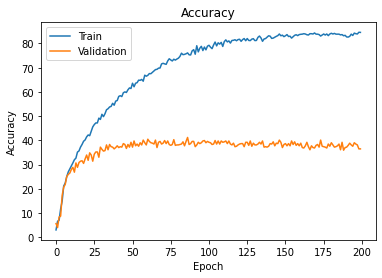

Finished Training
Precision by class: {0: 0.2727272727272727, 1: 0.6666666666666666, 2: 0.0, 3: 0.36363636363636365, 4: 0.42857142857142855, 5: 0.6818181818181818, 6: 1.0, 7: 0.0, 8: 0.0, 9: 0.5714285714285714, 10: 0.5, 11: 0.2857142857142857, 12: 0.3888888888888889, 13: 0.3333333333333333, 14: 0.46153846153846156, 15: 0.5, 16: 0.6666666666666666, 17: 0.42857142857142855, 18: 0.2, 19: 0.6363636363636364, 20: 0.4444444444444444, 21: 1.0, 22: 0.6428571428571429, 23: 0, 24: 0.2857142857142857, 25: 0.25, 26: 0.2916666666666667, 27: 0.5, 28: 0.36363636363636365, 29: 0.2727272727272727, 30: 0.5, 31: 0.6, 32: 0.0, 33: 0.5, 34: 0.75, 35: 0.05434782608695652, 36: 0.45, 37: 0.5454545454545454, 38: 0.45454545454545453, 39: 0.25, 40: 0.8888888888888888, 41: 0.6, 42: 0.7692307692307693, 43: 0.7, 44: 0.2857142857142857, 45: 0.6428571428571429, 46: 0.8461538461538461}
Recall by class: {0: 0.42857142857142855, 1: 0.11764705882352941, 2: 0.0, 3: 0.3333333333333333, 4: 0.3333333333333333, 5: 0.681818181

42.028985507246375

In [29]:
#model, train_loader, criterion, optimizer, device, num_epochs, num_classes
angle_train(mlp, train_loader, criterion, optimizer,hparams['device'], hparams['num_epochs'])
angle_test(mlp, test_loader,criterion)

#CombineMLP

In [30]:
torch.save(img_model.state_dict(), '/content/img_model_state_dict')
torch.save(mlp.state_dict(), '/content/angle_mlp_state_dict')

In [31]:
###WARNING: DO NOT RUN THIS CELL MORE THAN ONCE OR THE REST OF THE NOTEBOOK WILL NOT WORK
img_model.classifier = img_model.classifier[:-3]
mlp = nn.Sequential(*(list(mlp.children())[:-2]))

mlp.to(device)
img_model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [ ]:
img_model.load_state_dict(torch.load('/content/img_model_state_dict'), strict = False)
mlp.load_state_dict(torch.load('/content/angle_mlp_state_dict'), strict = False)

In [33]:
class CombinedDataset(Dataset):
    def __init__(self, dataset1, dataset2):
        self.d1 = dataset1
        self.d2 = dataset2
    
    def __getitem__(self, index):
        img, label1 = self.d1.__getitem__(index)
        angle, label2 = self.d2.__getitem__(index)

        if label1 != label2:
            print("[ERROR] Different labels with same index") 
        
        return img, angle, label1

    def __len__(self):
        if self.d1.__len__() != self.d2.__len__():
            print("[ERROR] Different size of datasets") 
        return len(self.d1)


In [34]:
train_combined = CombinedDataset(train_dataset, angles_train_dataset)
test_combined = CombinedDataset(test_dataset, angles_test_dataset)
val_combined = CombinedDataset(val_dataset, angles_val_dataset)

In [ ]:
image, angle, label = train_combined[145]

# convert the tensor image to a PIL Image
to_pil = ToPILImage()
pil_image = to_pil(image)

# plot the image and show its corresponding label
plt.imshow(pil_image)
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()

In [35]:
train_loader = DataLoader(dataset=train_combined, batch_size=hparams['batch_size'], shuffle=True)
val_loader = DataLoader(dataset=val_combined, batch_size=hparams['batch_size'], shuffle=False)
test_loader = DataLoader(dataset=test_combined, batch_size=hparams['batch_size'], shuffle=False)

In [36]:
class CombinedMLP(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(CombinedMLP, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.batch = nn.BatchNorm1d(hidden_size)
    self.drop1 = nn.Dropout(0.4)
    self.fc2 = nn.Linear(hidden_size, hidden_size)
    self.drop2 = nn.Dropout(0.4)
    self.fc3 = nn.Linear(hidden_size, output_size)
    self.logsoftmax = nn.LogSoftmax(dim = -1)

  def forward(self, x):
    out = self.fc1(x)
    out = self.relu(out)
    out = self.batch(out)
    out = self.drop1(out)
    out = self.fc2(out)
    out = self.relu(out)
    out = self.drop2(out)
    out = self.fc3(out)
    out = self.logsoftmax(out)

    return out

In [37]:
combined_mlp = CombinedMLP(input_size = 178, hidden_size = 100, output_size = num_classes)
combined_mlp.to(device)

CombinedMLP(
  (fc1): Linear(in_features=178, out_features=100, bias=True)
  (relu): ReLU()
  (batch): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop1): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (drop2): Dropout(p=0.4, inplace=False)
  (fc3): Linear(in_features=100, out_features=47, bias=True)
  (logsoftmax): LogSoftmax(dim=-1)
)

In [38]:
criterion = nn.NLLLoss()
optimizer = optim.AdamW(
    [
        {"params": img_model.features.parameters(), "lr": 1e-5},
        {"params": img_model.classifier.parameters(), "lr": 1e-4},
        {"params": mlp.parameters(), "lr": 1e-3},
        {"params": combined_mlp.parameters(), "lr": hparams['learning_rate']}
    ],weight_decay = 1e-6)

In [39]:
def combined_train(model, optimizer, criterion, train_loader, val_loader, num_epochs):
    for epoch in range(num_epochs):
        model.train()  # set the model to training mode
        img_model.train()
        mlp.train()
        train_loss = 0.0
        train_total = 0
        train_correct = 0

        # iterate over the train_loader to get the model outputs and labels
        for batch_idx, (images, angles, labels) in enumerate(train_loader):
            images = images.to(device)
            angles = angles.to(device)
            labels = labels.to(device)
            img_output = img_model(images)
            mlp_output = mlp(angles)
            combined_output = torch.cat((img_output, mlp_output), dim=1)

            # feed the combined output to the model and compute the loss
            optimizer.zero_grad()
            logits = model(combined_output)
            loss = criterion(logits, labels)

            # compute gradients and update parameters
            loss.backward()
            optimizer.step()

            # accumulate the training loss and accuracy
            train_loss += loss.item()
            _, predicted = torch.max(logits.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        # compute the average training loss and accuracy for the epoch
        train_loss /= len(train_loader)
        train_accuracy = 100 * train_correct / train_total
        print("Epoch {} - Training loss: {:.6f}, Training accuracy: {:.2f}%".format(epoch+1, train_loss, train_accuracy))

        # validate the model on the validation set
        val_loss, val_accuracy = combined_validate(model, criterion, val_loader)
        print("Epoch {} - Validation loss: {:.6f}, Validation accuracy: {:.2f}%".format(epoch+1, val_loss, val_accuracy))

In [40]:
def combined_validate(model, criterion, val_loader):
    model.eval()  # set the model to evaluation mode
    img_model.eval()
    mlp.eval()
    val_loss = 0.0
    val_acc = 0.0

    # disable gradient computation for validation
    with torch.no_grad():
        # iterate over the validation set to get the model outputs and labels
        for batch_idx, (images, angles, labels) in enumerate(val_loader):
            images = images.to(device)
            angles = angles.to(device)
            labels = labels.to(device)
            img_output = img_model(images)
            mlp_output = mlp(angles)
            combined_output = torch.cat((img_output, mlp_output), dim=1)

            # feed the combined output to the model and compute the loss
            logits = model(combined_output)
            loss = criterion(logits, labels)

            # accumulate the validation loss
            val_loss += loss.item()

            # compute the validation accuracy
            preds = torch.argmax(logits, dim=1)
            val_acc += torch.sum(preds == labels).item()

    # compute the average validation loss and accuracy
    val_loss /= len(val_loader)
    val_acc = (val_acc / len(val_loader.dataset)) * 100  # convert to percentage

    return val_loss, val_acc

In [41]:
classes = list(range(0,47))

In [42]:
def combined_test(model, criterion, test_loader):
    model.eval()  # set the model to evaluation mode
    img_model.eval()
    mlp.eval()
    test_loss = 0.0
    test_acc = 0.0
    preds_list = []
    labels_list = []

    # disable gradient computation for testing
    with torch.no_grad():
        # iterate over the test set to get the model outputs and labels
        for batch_idx, (images, angles, labels) in enumerate(test_loader):
            images = images.to(device)
            angles = angles.to(device)
            labels = labels.to(device)
            img_output = img_model(images)
            mlp_output = mlp(angles)
            combined_output = torch.cat((img_output, mlp_output), dim=1)

            # feed the combined output to the model and compute the loss
            logits = model(combined_output)
            loss = criterion(logits, labels)

            # accumulate the test loss
            test_loss += loss.item()

            # compute the test accuracy
            preds = torch.argmax(logits, dim=1)
            preds_list.append(preds.cpu())
            labels_list.append(labels.cpu())
            test_acc += torch.sum(preds == labels).item()

    preds = torch.cat(preds_list, dim=0)
    labels = torch.cat(labels_list, dim=0)
    cf_matrix = confusion_matrix(labels, preds)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index=[i for i in classes],
                         columns=[i for i in classes])
    plt.figure(figsize=(32, 21))
    sn.heatmap(df_cm, annot=True, cmap="Blues", square=True, fmt='.2f', xticklabels=sorted(list(poses_dict.keys())), yticklabels=sorted(list(poses_dict.keys())),
                cbar=False)
    report = classification_report(labels.cpu(), preds.cpu(), target_names=sorted(list(poses_dict.keys())))
    print(report)

    # compute the average test loss and accuracy
    test_loss /= len(test_loader)
    test_acc = (test_acc / len(test_loader.dataset)) * 100  # convert to percentage

    return test_loss, test_acc

In [43]:
combined_train(combined_mlp, optimizer, criterion, train_loader, val_loader, num_epochs = 30)

Epoch 1 - Training loss: 3.835870, Training accuracy: 3.69%
Epoch 1 - Validation loss: 3.679739, Validation accuracy: 16.33%
Epoch 2 - Training loss: 3.642490, Training accuracy: 8.11%
Epoch 2 - Validation loss: 3.495112, Validation accuracy: 20.33%
Epoch 3 - Training loss: 3.466205, Training accuracy: 11.80%
Epoch 3 - Validation loss: 3.259757, Validation accuracy: 25.77%
Epoch 4 - Training loss: 3.239042, Training accuracy: 16.33%
Epoch 4 - Validation loss: 2.969769, Validation accuracy: 30.85%
Epoch 5 - Training loss: 2.924879, Training accuracy: 23.84%
Epoch 5 - Validation loss: 2.646565, Validation accuracy: 33.58%
Epoch 6 - Training loss: 2.636481, Training accuracy: 28.25%
Epoch 6 - Validation loss: 2.347462, Validation accuracy: 39.38%
Epoch 7 - Training loss: 2.343291, Training accuracy: 33.64%
Epoch 7 - Validation loss: 2.051558, Validation accuracy: 48.46%
Epoch 8 - Training loss: 2.086004, Training accuracy: 41.38%
Epoch 8 - Validation loss: 1.822197, Validation accuracy: 5

In [44]:
combined_validate(combined_mlp, criterion, val_loader)

(0.8083799415164523, 74.22867513611615)

                               precision    recall  f1-score   support

         Adho Mukha Svanasana       0.62      0.71      0.67        14
         Adho Mukha Vrksasana       0.88      0.41      0.56        17
                    Alanasana       0.50      0.25      0.33         4
                 Anjaneyasana       0.67      0.67      0.67        12
            Ardha Chandrasana       0.80      0.89      0.84         9
         Ardha Matsyendrasana       0.88      0.95      0.91        22
               Ardha Navasana       0.33      0.50      0.40         2
      Ardha Pincha Mayurasana       0.44      0.33      0.38        12
            Ashta Chandrasana       0.00      0.00      0.00         1
              Baddha Konasana       0.85      0.69      0.76        16
                     Bakasana       0.79      0.92      0.85        12
                     Balasana       0.71      0.71      0.71        21
                   Bitilasana       0.93      0.81      0.87        16
     

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(2.1514539784855313, 76.81159420289855)

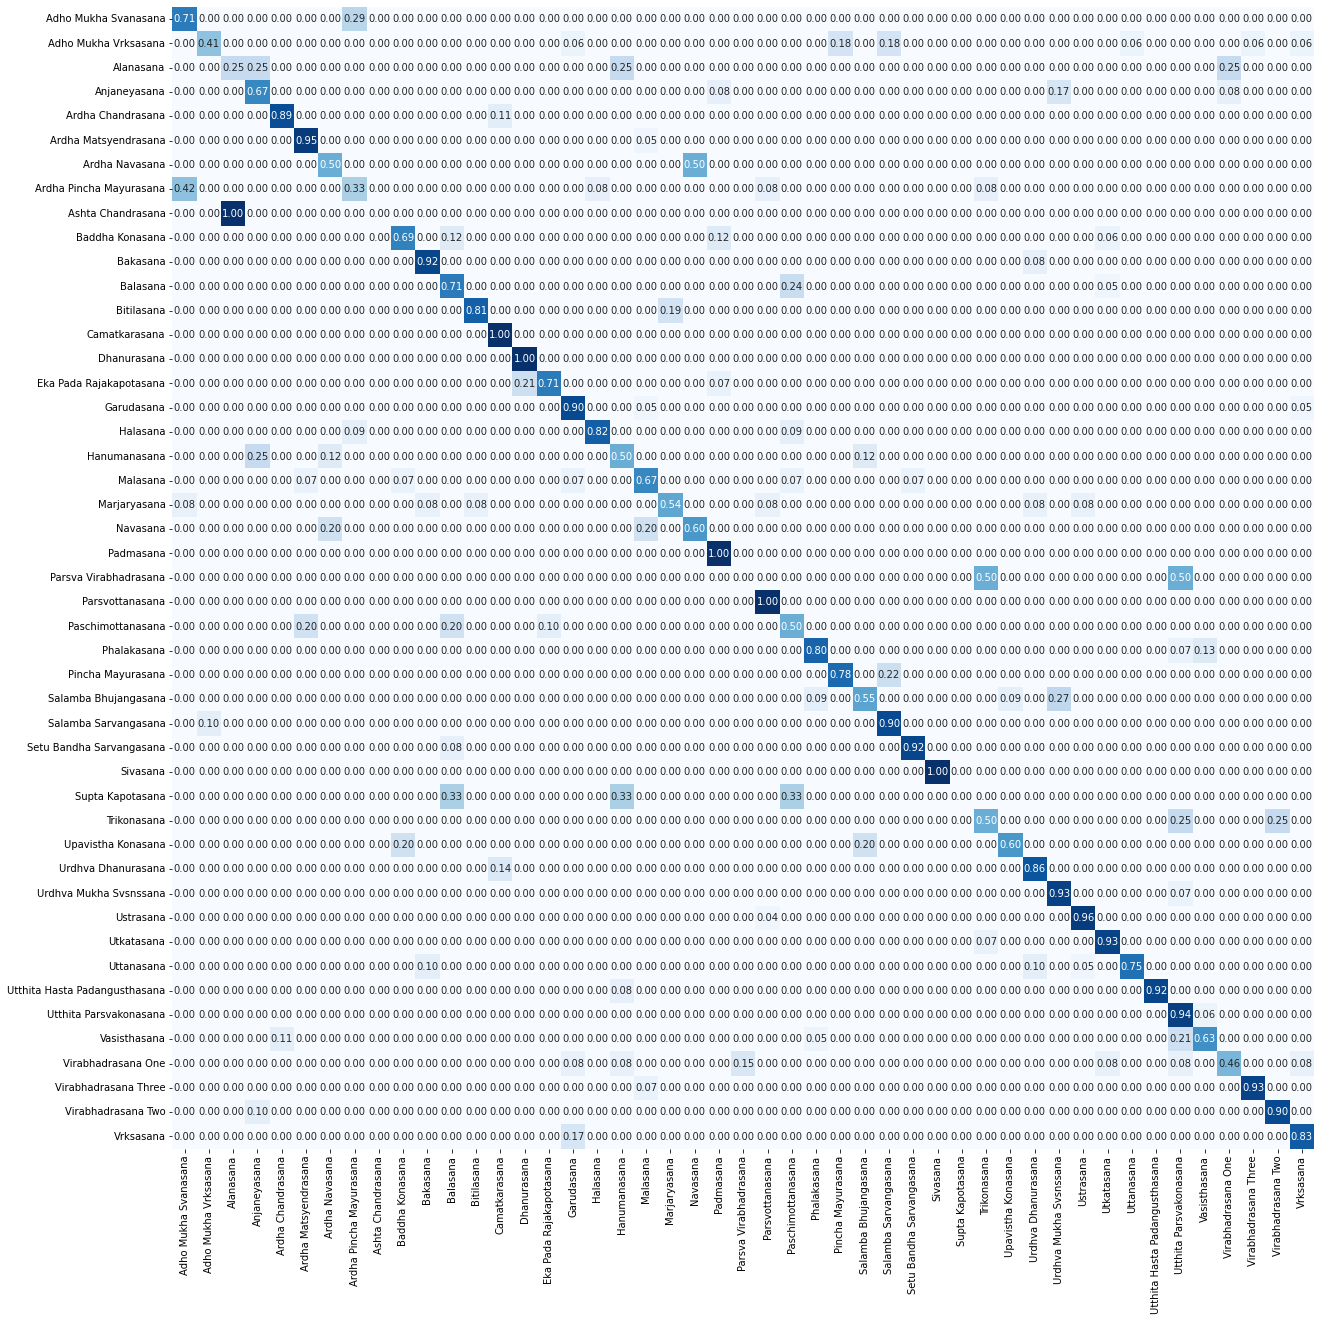

In [45]:
combined_test(combined_mlp, criterion, test_loader)